# Generate plots from saved runs

In [1]:
import warnings
import matplotlib
warnings.filterwarnings("ignore", category=matplotlib.MatplotlibDeprecationWarning)

In [2]:
# %matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
# import pandas as pd

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    'font.size': 16,
    'figure.dpi': 100
})
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FormatStrFormatter
from src.microcircuit import *
from src.save_exp import *
import sys
# import pandas as pd
plt.style.use('tableau-colorblind10')

#load autoreload, which automatically reloads the microcircuit.py upon execution
%reload_ext autoreload
%autoreload 1
%aimport src.microcircuit

In [3]:
# PATHS = ['experiments/exp39_errormc_multilayer/32-16-8-4-2-1/errormc/', 'experiments/exp55_errormc_multilayer/32-16-8-4-2-1/errormc/']
PATHS = ['experiments/exp56_debug_testloss_again/test is train/',
         'experiments/exp56_debug_testloss_again/train and test copy/',
         'experiments/exp56_debug_testloss_again/train and test copy 200 epochs/',
         'experiments/exp56_debug_testloss_again/train and test copy 1 epoch/']

In [167]:
network_list = []

for PATH in PATHS:
    model_file = PATH + 'model.pkl'
    MC_list = src.save_exp.load(model_file)
    network_list.append(MC_list)

0 0.0038144261643878867
1 0.11757751867640641
2 0.12251139528283625
3 0.25656696298171344


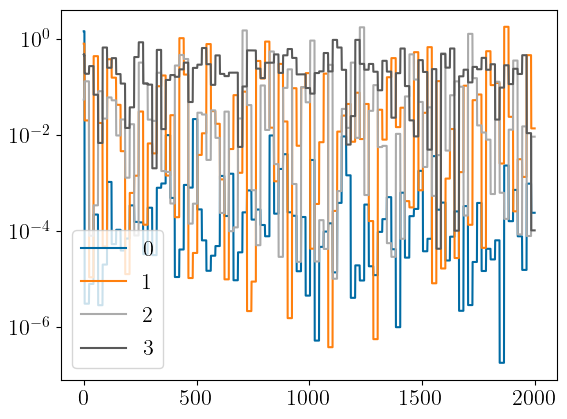

In [169]:
plt.figure()
for i, net in enumerate(network_list):
    data = net[-1].MSE_test_time_series
    plt.plot(data, label=i)
    print(i, np.mean(data))
plt.yscale('log')
plt.legend()
plt.show()

In [137]:
sizes = {}
for name in network_list[0][-1].__dict__:
    x = getattr(network_list[1][-1], name)
    size = len(dill.dumps(x))/1024**2
#     print(name, str(size) + " MB")
    sizes[name] = size
    
for k in sorted(sizes, key=sizes.get, reverse=True):
    print(k, str(sizes[k]) + " MB")
    
print("################################")
print("total size: " + str(sum(sizes.values())) + " MB")

WPP_time_series 0.5394191741943359 MB
input 0.4884681701660156 MB
input_testing 0.4884681701660156 MB
MSE_test_time_series 0.036337852478027344 MB
target 0.015437126159667969 MB
target_testing 0.015437126159667969 MB
WPP 0.00553131103515625 MB
dWPP 0.00553131103515625 MB
dBPP 0.00553131103515625 MB
dWPP_LO 0.00553131103515625 MB
WIP 0.0029268264770507812 MB
BPI 0.0029268264770507812 MB
dWIP 0.0029268264770507812 MB
dBPI 0.0029268264770507812 MB
rng 0.00272369384765625 MB
MSE_time_series 0.0019083023071289062 MB
BPP 0.0015869140625 MB
BII 0.0015869140625 MB
dBII 0.0015869140625 MB
uP 0.0005464553833007812 MB
uI 0.0005464553833007812 MB
uP_old 0.0005464553833007812 MB
uI_old 0.0005464553833007812 MB
vbas 0.0005464553833007812 MB
vden 0.0005464553833007812 MB
vapi 0.0005464553833007812 MB
vbas_old 0.0005464553833007812 MB
vden_old 0.0005464553833007812 MB
vapi_old 0.0005464553833007812 MB
uP_breve 0.0005464553833007812 MB
uI_breve 0.0005464553833007812 MB
rP_breve 0.0005464553833007812 MB

In [147]:
sizes = {}
for name in network_list[1][-1].__dict__:
    x = getattr(network_list[1][-1], name)
    size = len(dill.dumps(x))/1024**2
#     print(name, str(size) + " MB")
    sizes[name] = size
    
sizes.pop('dWPP_time_series_compare', None)
sizes.pop('dWPP_time_series_BP_ANN', None)
    
for k in sorted(sizes, key=sizes.get, reverse=True):
    print(k, str(sizes[k]) + " MB")


print("################################")
print("total size: " + str(sum(sizes.values())) + " MB")

angle_BP_updates_time_series 0.8593807220458984 MB
WPP_time_series 0.5394191741943359 MB
input 0.4884681701660156 MB
input_testing 0.4884681701660156 MB
WIP_time_series 0.27893638610839844 MB
BPI_time_series 0.27893638610839844 MB
BII_time_series 0.144927978515625 MB
uP_breve_time_series 0.04086494445800781 MB
uI_breve_time_series 0.04086494445800781 MB
vbas_time_series 0.04086494445800781 MB
MSE_test_time_series 0.036337852478027344 MB
target 0.015437126159667969 MB
target_testing 0.015437126159667969 MB
angle_BII_RHS_time_series 0.007725715637207031 MB
WPP 0.00553131103515625 MB
dWPP 0.00553131103515625 MB
dBPP 0.00553131103515625 MB
dWPP_LO 0.00553131103515625 MB
angle_WPPT_BII_time_series 0.0038299560546875 MB
WIP 0.0029268264770507812 MB
BPI 0.0029268264770507812 MB
dWIP 0.0029268264770507812 MB
dBPI 0.0029268264770507812 MB
rng 0.00272369384765625 MB
MSE_time_series 0.0019083023071289062 MB
BPP 0.0015869140625 MB
BII 0.0015869140625 MB
dBII 0.0015869140625 MB
BII_noise 0.00158691

In [140]:
len(network_list[1][-1].dWPP_time_series_BP_ANN)

10000

In [141]:
len(network_list[1][-1].WPP_time_series)

100

# Implement skip fwd connections

In [1]:
import warnings
import matplotlib
warnings.filterwarnings("ignore", category=matplotlib.MatplotlibDeprecationWarning)

In [2]:
# %matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
# import pandas as pd

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    'font.size': 16,
    'figure.dpi': 100
})
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FormatStrFormatter
from src.microcircuit import *
from src.save_exp import *
import sys
# import pandas as pd
plt.style.use('tableau-colorblind10')

#load autoreload, which automatically reloads the microcircuit.py upon execution
%reload_ext autoreload
%autoreload 1
%aimport src.microcircuit

np.set_printoptions(precision=4,linewidth=1000)

## Reproduce same results for skip fwd and layered fwd with layered swd

### Setup

In [16]:
# simulation settings

dt = 0.01 # in ms
tauxi = None
Tpres = 20 * dt
Ttot = 10 * Tpres # total simulation time

In [17]:
# common parameters

np.random.seed(1234)

# Init model: weights, voltages

layers = [1, 1, 1]
error_layers = [0] + layers[1:]

# conductances
gl = 0.03
gbas = 0.1
gapi = 0.06
gden = 0.1
gnI = 0.06
gntgt = 0.06

# learning rates in 1/ms
# eta_fw = [0.0] * (len(layers) - 1)
# eta_fw = [[0.0] * (len(layers) - 1)] * (len(layers) - 1)
# eta_fw = [[1.0,0.0],[-1.0,1.0]]
eta_bw = [0.0] * (len(layers) - 2)
eta_IP = [0.0] * (len(layers) - 1)
eta_PI = [0.0] * (len(layers) - 1)

# activation function
act_func_list = [logistic] * (len(layers) - 2) + [linear]

# initialise voltages
uP_init = []
for i in range(1, len(layers)):
    uP_init.append(np.random.normal(0, 1, size=layers[i]))
    
uI_init = []
for i in range(1, len(layers)):
    uI_init.append(np.random.normal(0, 1, size=error_layers[i]))
    
# forward pp weights: skip connections
# WPP_init = []
# for i in range(len(layers)-1):
#     WPP_init.append(np.random.uniform(-1, 1, size=(layers[i+1], layers[i])))
# WPP_init = init_nonhierarchical_WPP([1,1], layers, [0,0])

# rep to error: connects k to k
WIP_init = []
for i in range(1, len(layers)):
#     WIP_init.append(np.random.uniform(-1, 1, size=(layers[i], layers[i])))
    WIP_init.append(np.eye(N=layers[i], M=layers[i]))

# backwards error to error: skip connections
# BII_init = init_nonhierarchical_BII([2,2], error_layers, [-0.8,-0.8])
BII_init = []
for i in range(1, len(error_layers)-1):
    BII_init.append(np.random.uniform(-1, 1, size=(error_layers[i], error_layers[i+1])))


# error to rep: connects k to k
BPI_init = []
for i in range(1, len(layers)):
#     BPI_init.append(np.random.uniform(-1, 1, size=(layers[i], layers[i])))
    BPI_init.append(np.eye(N=layers[i], M=layers[i]))

In [18]:
np.random.seed(1234)

eta_fw = [[1.0,0.0],[0.0,1.0]]
    
# forward pp weights: skip connections
WPP_init = init_nonhierarchical_WPP([1,1], layers, [0,0])


    
mc1_skip = errormc_model(fw_connection_mode='skip',
                 bw_connection_mode='layered',
                 dWPP_use_activation=True,
                 varphi_transfer=True,
                 dt=dt, 
                 dtxi=dt,
                 tauHP=dt,
                 tauLO=dt,
                 Tpres=Tpres,
                 noise_scale=dt,
                 alpha=None,
                 pyr_hi_pass=False,
                 dWPP_low_pass=False,
                 noise_type=None,
                 noise_mode='vapi',
                 model='FA', 
                 activation=act_func_list,
                 error_activation=linear,
                 layers=layers,
                 uP_init=uP_init, 
                 uI_init=uI_init,
                 WPP_init=WPP_init, 
                 WIP_init=WIP_init, 
                 BII_init=BII_init, 
                 BPI_init=BPI_init,
                 gl=gl, 
                 gden=gden, 
                 gbas=gbas, 
                 gapi=gapi, 
                 gnI=gnI, 
                 gntgt=gntgt,
                 eta_fw=eta_fw, 
                 eta_bw=eta_bw, 
                 eta_PI=eta_PI, 
                 eta_IP=eta_IP)

In [19]:
np.random.seed(1234)

eta_fw = [1.0,1.0]
    
# forward pp weights: skip connections
WPP_init = []
for i in range(len(layers)-1):
    WPP_init.append(np.random.uniform(1, 1, size=(layers[i+1], layers[i])))
# WPP_init = init_nonhierarchical_WPP([1,1], layers, [0,0])


    
mc1_layered = errormc_model(fw_connection_mode='layered',
                 bw_connection_mode='layered',
                 dWPP_use_activation=True,
                 varphi_transfer=True,
                 dt=dt, 
                 dtxi=dt,
                 tauHP=dt,
                 tauLO=dt,
                 Tpres=Tpres,
                 noise_scale=dt,
                 alpha=None,
                 pyr_hi_pass=False,
                 dWPP_low_pass=False,
                 noise_type=None,
                 noise_mode='vapi',
                 model='FA', 
                 activation=act_func_list,
                 error_activation=linear,
                 layers=layers,
                 uP_init=uP_init, 
                 uI_init=uI_init,
                 WPP_init=WPP_init, 
                 WIP_init=WIP_init, 
                 BII_init=BII_init, 
                 BPI_init=BPI_init,
                 gl=gl, 
                 gden=gden, 
                 gbas=gbas, 
                 gapi=gapi, 
                 gnI=gnI, 
                 gntgt=gntgt,
                 eta_fw=eta_fw, 
                 eta_bw=eta_bw, 
                 eta_PI=eta_PI, 
                 eta_IP=eta_IP)

In [20]:
# input rates: step functions in the form of random inputs held for Tpres

r0_random = np.random.uniform(0, 1, size=(int(Tpres / dt), layers[0]))
r0_random = np.repeat(r0_random, int(Ttot / Tpres), axis=0)

# target time series: random

targets = np.random.uniform(0, 1, size=(int(Tpres / dt), layers[-1]))
targets = np.repeat(targets, int(Ttot / Tpres), axis=0)

### Simulation

In [21]:
# init recording of params
mc1_skip.init_record(rec_per_steps=1, rec_uI_breve=True, rec_uP_breve=True, 
                rec_rI_breve=True, rec_rP_breve=True, rec_uP=True, rec_uI=True, 
                rec_WPP=True, rec_BII=True, rec_WIP=True, rec_BPI=True, rec_vapi=True)

# run model
for i in range(len(r0_random)):
    mc1_skip.evolve_system(r0=r0_random[i], u_tgt=targets[i])

In [22]:


# init recording of params
mc1_layered.init_record(rec_per_steps=1, rec_uI_breve=True, rec_uP_breve=True, 
                rec_rI_breve=True, rec_rP_breve=True, rec_uP=True, rec_uI=True, 
                rec_WPP=True, rec_BII=True, rec_WIP=True, rec_BPI=True, rec_vapi=True)

# run model
for i in range(len(r0_random)):
    mc1_layered.evolve_system(r0=r0_random[i], u_tgt=targets[i])

### Evaluation

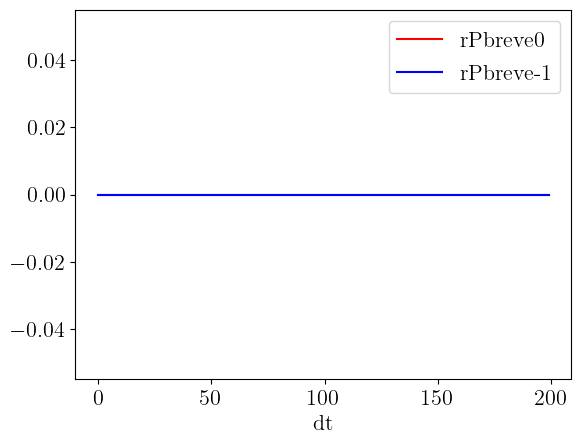

In [23]:
# Check that rP_breve is the same for both models

fig = plt.figure()

diff = [rPbreve_skip[0] - rPbreve_layered[0] for rPbreve_skip, rPbreve_layered in zip(mc1_skip.rP_breve_time_series, mc1_layered.rP_breve_time_series)]
plt.plot(np.array(diff).ravel(), label="rPbreve0", color='r')

diff = [rPbreve_skip[-1] - rPbreve_layered[-1] for rPbreve_skip, rPbreve_layered in zip(mc1_skip.rP_breve_time_series, mc1_layered.rP_breve_time_series)]
plt.plot(np.array(diff).ravel(), label="rPbreve-1", color='b')

plt.legend()
plt.xlabel('dt')
plt.show()

## Reproduce same results for skip fwd and layered fwd with skip bwd

### Setup

In [16]:
# simulation settings

dt = 0.01 # in ms
tauxi = None
Tpres = 20 * dt
Ttot = 10 * Tpres # total simulation time

In [17]:
# common parameters

np.random.seed(1234)

# Init model: weights, voltages

layers = [1, 1, 1]
error_layers = [0] + layers[1:]

# conductances
gl = 0.03
gbas = 0.1
gapi = 0.06
gden = 0.1
gnI = 0.06
gntgt = 0.06

# learning rates in 1/ms
# eta_fw = [0.0] * (len(layers) - 1)
# eta_fw = [[0.0] * (len(layers) - 1)] * (len(layers) - 1)
# eta_fw = [[1.0,0.0],[-1.0,1.0]]
eta_bw = [0.0] * (len(layers) - 2)
eta_IP = [0.0] * (len(layers) - 1)
eta_PI = [0.0] * (len(layers) - 1)

# activation function
act_func_list = [logistic] * (len(layers) - 2) + [linear]

# initialise voltages
uP_init = []
for i in range(1, len(layers)):
    uP_init.append(np.random.normal(0, 1, size=layers[i]))
    
uI_init = []
for i in range(1, len(layers)):
    uI_init.append(np.random.normal(0, 1, size=error_layers[i]))
    
# forward pp weights: skip connections
# WPP_init = []
# for i in range(len(layers)-1):
#     WPP_init.append(np.random.uniform(-1, 1, size=(layers[i+1], layers[i])))
# WPP_init = init_nonhierarchical_WPP([1,1], layers, [0,0])

# rep to error: connects k to k
WIP_init = []
for i in range(1, len(layers)):
#     WIP_init.append(np.random.uniform(-1, 1, size=(layers[i], layers[i])))
    WIP_init.append(np.eye(N=layers[i], M=layers[i]))

# backwards error to error: skip connections
BII_init = init_nonhierarchical_BII([2,2], error_layers, [-0.8,-0.8])
# BII_init = []
# for i in range(1, len(error_layers)-1):
#     BII_init.append(np.random.uniform(-1, 1, size=(error_layers[i], error_layers[i+1])))


# error to rep: connects k to k
BPI_init = []
for i in range(1, len(layers)):
#     BPI_init.append(np.random.uniform(-1, 1, size=(layers[i], layers[i])))
    BPI_init.append(np.eye(N=layers[i], M=layers[i]))

In [31]:
np.random.seed(1234)

eta_fw = [[1.0,0.0],[0.0,1.0]]
    
# forward pp weights: skip connections
WPP_init = init_nonhierarchical_WPP([1,1], layers, [0,0])


    
mc1_skip = errormc_model(fw_connection_mode='skip',
                 bw_connection_mode='skip',
                 dWPP_use_activation=True,
                 varphi_transfer=True,
                 dt=dt, 
                 dtxi=dt,
                 tauHP=dt,
                 tauLO=dt,
                 Tpres=Tpres,
                 noise_scale=dt,
                 alpha=None,
                 pyr_hi_pass=False,
                 dWPP_low_pass=False,
                 noise_type=None,
                 noise_mode='vapi',
                 model='FA', 
                 activation=act_func_list,
                 error_activation=linear,
                 layers=layers,
                 uP_init=uP_init, 
                 uI_init=uI_init,
                 WPP_init=WPP_init, 
                 WIP_init=WIP_init, 
                 BII_init=BII_init, 
                 BPI_init=BPI_init,
                 gl=gl, 
                 gden=gden, 
                 gbas=gbas, 
                 gapi=gapi, 
                 gnI=gnI, 
                 gntgt=gntgt,
                 eta_fw=eta_fw, 
                 eta_bw=eta_bw, 
                 eta_PI=eta_PI, 
                 eta_IP=eta_IP)

In [32]:
np.random.seed(1234)

eta_fw = [1.0,1.0]
    
# forward pp weights: skip connections
WPP_init = []
for i in range(len(layers)-1):
    WPP_init.append(np.random.uniform(1, 1, size=(layers[i+1], layers[i])))
# WPP_init = init_nonhierarchical_WPP([1,1], layers, [0,0])


    
mc1_layered = errormc_model(fw_connection_mode='layered',
                 bw_connection_mode='skip',
                 dWPP_use_activation=True,
                 varphi_transfer=True,
                 dt=dt, 
                 dtxi=dt,
                 tauHP=dt,
                 tauLO=dt,
                 Tpres=Tpres,
                 noise_scale=dt,
                 alpha=None,
                 pyr_hi_pass=False,
                 dWPP_low_pass=False,
                 noise_type=None,
                 noise_mode='vapi',
                 model='FA', 
                 activation=act_func_list,
                 error_activation=linear,
                 layers=layers,
                 uP_init=uP_init, 
                 uI_init=uI_init,
                 WPP_init=WPP_init, 
                 WIP_init=WIP_init, 
                 BII_init=BII_init, 
                 BPI_init=BPI_init,
                 gl=gl, 
                 gden=gden, 
                 gbas=gbas, 
                 gapi=gapi, 
                 gnI=gnI, 
                 gntgt=gntgt,
                 eta_fw=eta_fw, 
                 eta_bw=eta_bw, 
                 eta_PI=eta_PI, 
                 eta_IP=eta_IP)

In [33]:
# input rates: step functions in the form of random inputs held for Tpres

r0_random = np.random.uniform(0, 1, size=(int(Tpres / dt), layers[0]))
r0_random = np.repeat(r0_random, int(Ttot / Tpres), axis=0)

# target time series: random

targets = np.random.uniform(0, 1, size=(int(Tpres / dt), layers[-1]))
targets = np.repeat(targets, int(Ttot / Tpres), axis=0)

### Simulation

In [34]:
# init recording of params
mc1_skip.init_record(rec_per_steps=1, rec_uI_breve=True, rec_uP_breve=True, 
                rec_rI_breve=True, rec_rP_breve=True, rec_uP=True, rec_uI=True, 
                rec_WPP=True, rec_BII=True, rec_WIP=True, rec_BPI=True, rec_vapi=True)

# run model
for i in range(len(r0_random)):
    mc1_skip.evolve_system(r0=r0_random[i], u_tgt=targets[i])

In [35]:


# init recording of params
mc1_layered.init_record(rec_per_steps=1, rec_uI_breve=True, rec_uP_breve=True, 
                rec_rI_breve=True, rec_rP_breve=True, rec_uP=True, rec_uI=True, 
                rec_WPP=True, rec_BII=True, rec_WIP=True, rec_BPI=True, rec_vapi=True)

# run model
for i in range(len(r0_random)):
    mc1_layered.evolve_system(r0=r0_random[i], u_tgt=targets[i])

### Evaluation

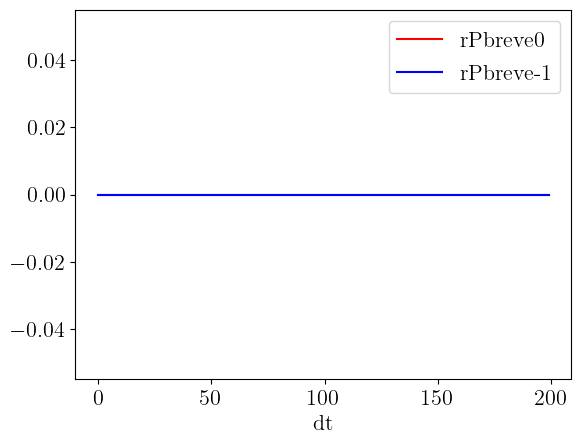

In [36]:
# Check that rP_breve is the same for both models

fig = plt.figure()

diff = [rPbreve_skip[0] - rPbreve_layered[0] for rPbreve_skip, rPbreve_layered in zip(mc1_skip.rP_breve_time_series, mc1_layered.rP_breve_time_series)]
plt.plot(np.array(diff).ravel(), label="rPbreve0", color='r')

diff = [rPbreve_skip[-1] - rPbreve_layered[-1] for rPbreve_skip, rPbreve_layered in zip(mc1_skip.rP_breve_time_series, mc1_layered.rP_breve_time_series)]
plt.plot(np.array(diff).ravel(), label="rPbreve-1", color='b')

plt.legend()
plt.xlabel('dt')
plt.show()

## See time scale of forward propagation (skip vs layered)

### Setup

In [3]:
# simulation settings

dt = 0.01 # in ms
tauxi = None
Tpres = 20 * dt
Ttot = 3 * Tpres # total simulation time

In [4]:
# common parameters

np.random.seed(1234)

# Init model: weights, voltages

layers = [1, 1, 1]
error_layers = [0] + layers[1:]

# conductances
gl = 0.03
gbas = 0.1
gapi = 0.06
gden = 0.1
gnI = 0.06
gntgt = 0.06

# learning rates in 1/ms
# eta_fw = [0.0] * (len(layers) - 1)
# eta_fw = [[0.0] * (len(layers) - 1)] * (len(layers) - 1)
# eta_fw = [[1.0,0.0],[-1.0,1.0]]
eta_bw = [0.0] * (len(layers) - 2)
eta_IP = [0.0] * (len(layers) - 1)
eta_PI = [0.0] * (len(layers) - 1)

# activation function
act_func_list = [logistic] * (len(layers) - 2) + [linear]

# initialise voltages
uP_init = []
for i in range(1, len(layers)):
    uP_init.append(np.random.normal(0, 1, size=layers[i]))
    
uI_init = []
for i in range(1, len(layers)):
    uI_init.append(np.random.normal(0, 1, size=error_layers[i]))
    
# forward pp weights: skip connections
# WPP_init = []
# for i in range(len(layers)-1):
#     WPP_init.append(np.random.uniform(-1, 1, size=(layers[i+1], layers[i])))
# WPP_init = init_nonhierarchical_WPP([1,1], layers, [0,0])

# rep to error: connects k to k
WIP_init = []
for i in range(1, len(layers)):
#     WIP_init.append(np.random.uniform(-1, 1, size=(layers[i], layers[i])))
    WIP_init.append(np.eye(N=layers[i], M=layers[i]))

# backwards error to error: skip connections
# BII_init = init_nonhierarchical_BII([2,2], error_layers, [-0.8,-0.8])
BII_init = []
for i in range(1, len(error_layers)-1):
    BII_init.append(np.random.uniform(-1, 1, size=(error_layers[i], error_layers[i+1])))


# error to rep: connects k to k
BPI_init = []
for i in range(1, len(layers)):
#     BPI_init.append(np.random.uniform(-1, 1, size=(layers[i], layers[i])))
    BPI_init.append(np.eye(N=layers[i], M=layers[i]))

In [5]:
np.random.seed(1234)

eta_fw = [[1.0,0.0],[0.0,1.0]]
    
# forward pp weights: skip connections
WPP_init = init_nonhierarchical_WPP([1,1], layers, [-1,-1])


    
mc1_skip = errormc_model(fw_connection_mode='skip',
                 bw_connection_mode='layered',
                 dWPP_use_activation=True,
                 varphi_transfer=True,
                 dt=dt, 
                 dtxi=dt,
                 tauHP=dt,
                 tauLO=dt,
                 Tpres=Tpres,
                 noise_scale=dt,
                 alpha=None,
                 pyr_hi_pass=False,
                 dWPP_low_pass=False,
                 noise_type=None,
                 noise_mode='vapi',
                 model='FA', 
                 activation=act_func_list,
                 error_activation=linear,
                 layers=layers,
                 uP_init=uP_init, 
                 uI_init=uI_init,
                 WPP_init=WPP_init, 
                 WIP_init=WIP_init, 
                 BII_init=BII_init, 
                 BPI_init=BPI_init,
                 gl=gl, 
                 gden=gden, 
                 gbas=gbas, 
                 gapi=gapi, 
                 gnI=gnI, 
                 gntgt=gntgt,
                 eta_fw=eta_fw, 
                 eta_bw=eta_bw, 
                 eta_PI=eta_PI, 
                 eta_IP=eta_IP)

In [6]:
np.random.seed(1234)

eta_fw = [1.0,1.0]
    
# forward pp weights: skip connections
WPP_init = []
for i in range(len(layers)-1):
    WPP_init.append(np.random.uniform(1, 1, size=(layers[i+1], layers[i])))
# WPP_init = init_nonhierarchical_WPP([1,1], layers, [0,0])


    
mc1_layered = errormc_model(fw_connection_mode='layered',
                 bw_connection_mode='layered',
                 dWPP_use_activation=True,
                 varphi_transfer=True,
                 dt=dt, 
                 dtxi=dt,
                 tauHP=dt,
                 tauLO=dt,
                 Tpres=Tpres,
                 noise_scale=dt,
                 alpha=None,
                 pyr_hi_pass=False,
                 dWPP_low_pass=False,
                 noise_type=None,
                 noise_mode='vapi',
                 model='FA', 
                 activation=act_func_list,
                 error_activation=linear,
                 layers=layers,
                 uP_init=uP_init, 
                 uI_init=uI_init,
                 WPP_init=WPP_init, 
                 WIP_init=WIP_init, 
                 BII_init=BII_init, 
                 BPI_init=BPI_init,
                 gl=gl, 
                 gden=gden, 
                 gbas=gbas, 
                 gapi=gapi, 
                 gnI=gnI, 
                 gntgt=gntgt,
                 eta_fw=eta_fw, 
                 eta_bw=eta_bw, 
                 eta_PI=eta_PI, 
                 eta_IP=eta_IP)

In [7]:
# input rates: step functions in the form of random inputs held for Tpres

r0_random = np.linspace(-3, 3, int(Ttot / Tpres))
r0_random = np.repeat(r0_random[:, np.newaxis], layers[0], axis=1)
r0_random = np.repeat(r0_random, int(Tpres / dt), axis=0)

# r0_random = np.random.uniform(0, 1, size=(int(Ttot / Tpres), layers[0]))
# r0_random = np.repeat(r0_random, int(Tpres / dt), axis=0)

# target time series: random

targets = np.random.uniform(0, 1, size=(int(Ttot / Tpres), layers[-1]))
targets = np.repeat(targets, int(Tpres / dt), axis=0)

### Simulation

In [8]:
# init recording of params
mc1_skip.init_record(rec_per_steps=1, rec_uI_breve=True, rec_uP_breve=True, 
                rec_rI_breve=True, rec_rP_breve=True, rec_uP=True, rec_uI=True, 
                rec_WPP=True, rec_BII=True, rec_WIP=True, rec_BPI=True, rec_vapi=True)

# run model
for i in range(len(r0_random)):
    mc1_skip.evolve_system(r0=r0_random[i])

In [9]:


# init recording of params
mc1_layered.init_record(rec_per_steps=1, rec_uI_breve=True, rec_uP_breve=True, 
                rec_rI_breve=True, rec_rP_breve=True, rec_uP=True, rec_uI=True, 
                rec_WPP=True, rec_BII=True, rec_WIP=True, rec_BPI=True, rec_vapi=True)

# run model
for i in range(len(r0_random)):
    mc1_layered.evolve_system(r0=r0_random[i])

### Evaluation

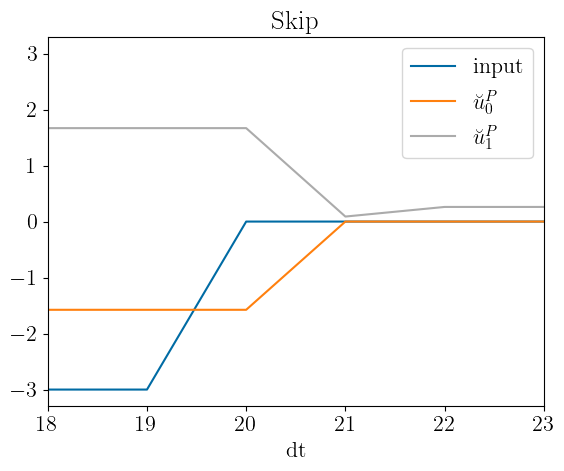

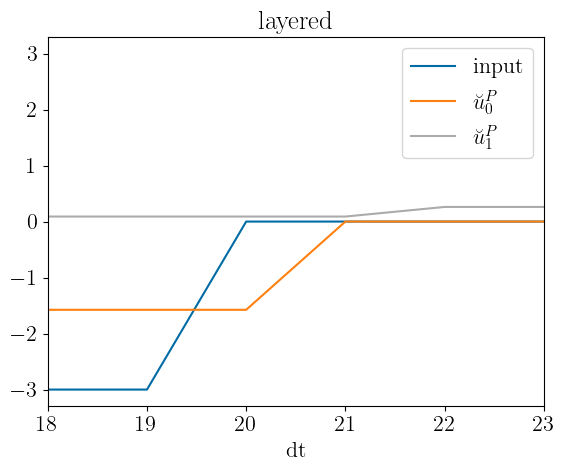

In [13]:
mc = mc1_skip

fig = plt.figure()
plt.plot(r0_random, label="input")

for i in range(len(layers[1:])):
    plt.plot([vec[i] for vec in mc.uP_breve_time_series], label="$\\breve{u}^P_" + str(i) + "$")

plt.legend()
plt.title("Skip")
plt.xlabel("dt")
plt.xlim(18,23)
plt.show()

mc = mc1_layered

fig = plt.figure()
plt.plot(r0_random, label="input")

for i in range(len(layers[1:])):
    plt.plot([vec[i] for vec in mc.uP_breve_time_series], label="$\\breve{u}^P_" + str(i) + "$")

plt.legend()
plt.title("layered")
plt.xlabel("dt")
plt.xlim(18,23)
plt.show()

# Noise on activation functions

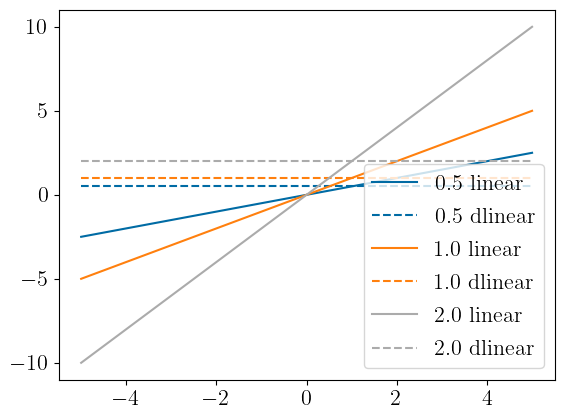

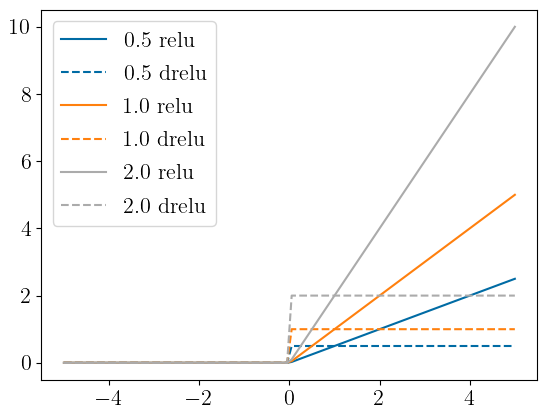

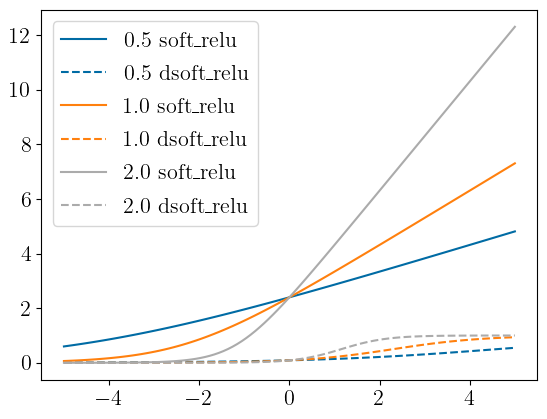

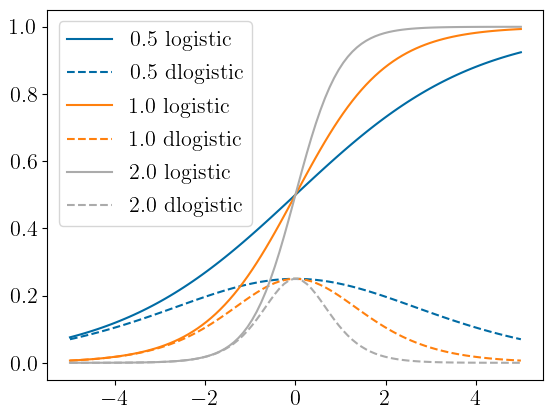

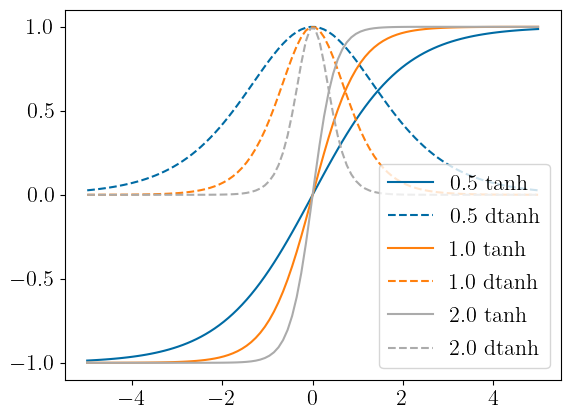

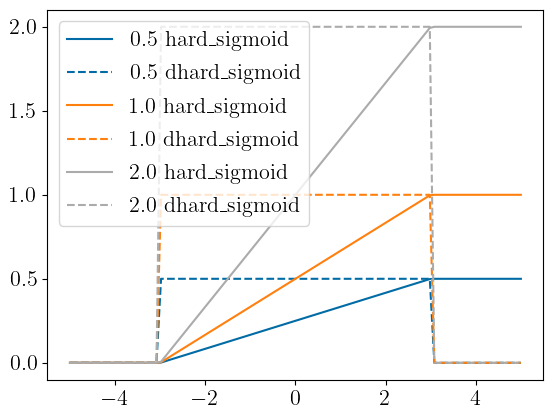

In [16]:
x = np.linspace(-5, 5, 100)

for act in [linear, relu, soft_relu, logistic, tanh, hard_sigmoid]:
    plt.plot()
    for slope, c in zip([0.5, 1.0, 2.0], ['C0', 'C1', 'C2']):
        y = act(x, slope=slope)
        plt.plot(x, y, label=str(slope) + str(" " + act.__name__).replace('_','\_'), c=c)
        
        d_act = dict_d_activation[act.__name__]
        y = d_act(x, slope=slope)
        plt.plot(x, y, label=str(slope) + str(" d" + act.__name__).replace('_','\_'), ls='--', c=c)

    
    
    plt.legend()
    plt.show()

In [41]:
import functools

In [82]:
f1 = tanh

In [85]:
f2 = functools.partial(f1, slope=1.5)

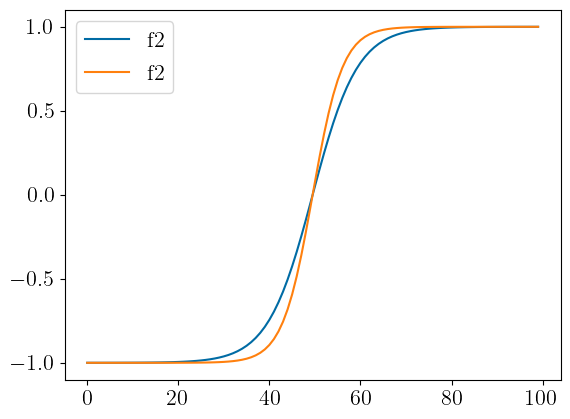

In [86]:
x = np.linspace(-5, 5, 100)

plt.figure()

plt.plot(f1(x), label="f2")
plt.plot(f2(x), label="f2")

plt.legend()

plt.show()

In [54]:
# check that teacher has no act func noise

MC_list = src.save_exp.load('experiments/exp61_implement_skip_fw/t_emc_s_emc_FA_fwskip_bwskip_actfuncnoise/model.pkl')

In [57]:
MC_list[0].activation

[<function src.microcircuit.tanh(x, slope=1.0)>,
 <function src.microcircuit.tanh(x, slope=1.0)>]

In [58]:
MC_list[1].activation

[functools.partial(<function tanh at 0x133221300>, slope=0.7775551432035094),
 functools.partial(<function tanh at 0x133221300>, slope=1.2922920557945408)]

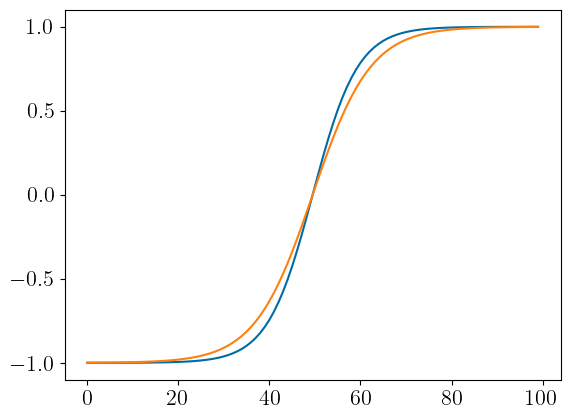

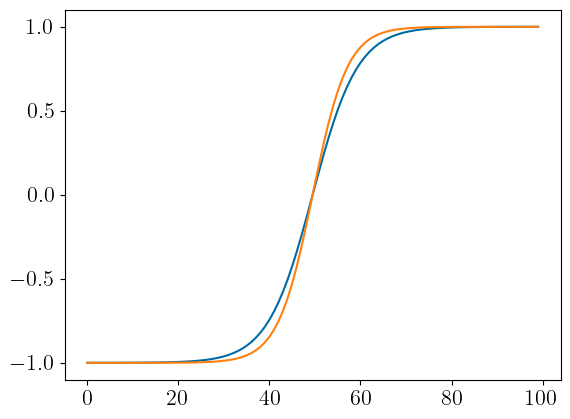

In [59]:
x = np.linspace(-5, 5, 100)

for f1, f2 in zip(MC_list[0].activation, MC_list[1].activation):

    plt.figure()

    plt.plot(f1(x))
    plt.plot(f2(x))

    plt.show()

In [94]:
# check different populations

MC_list = src.save_exp.load('experiments/exp61_implement_skip_fw/t_emc_s_emc_BP_layered_diffpopulations/model.pkl')

In [98]:
MC_list[1].error_layers

[0, 2, 1]

## Offset on activation function

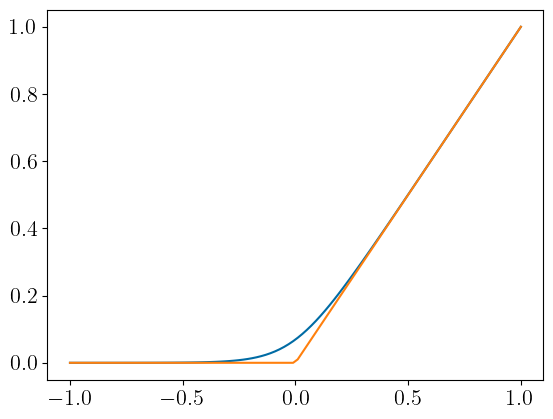

In [75]:
x = np.linspace(-1, 1, 100)
plt.plot()
slope = 1

plt.plot(x, soft_relu(x, slope=slope))
plt.plot(x, relu(x, slope=slope))
plt.show()

In [74]:
x = []

/var/folders/zb/q43ry99x69g19b1w0cyrrr700000gn/T/ipykernel_37878/2006519253.py:1: RuntimeWarning: overflow encountered in exp
  np.exp(1000)


inf

In [61]:
(x > 10) * 0.5 + (x <= 10) * 1

array([1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1.5, 1.5, 1.5,
       1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5,
       1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5])

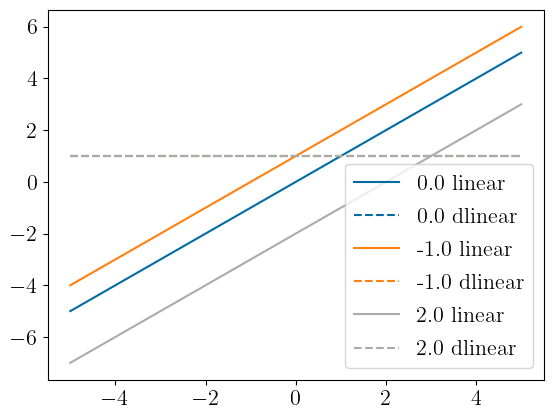

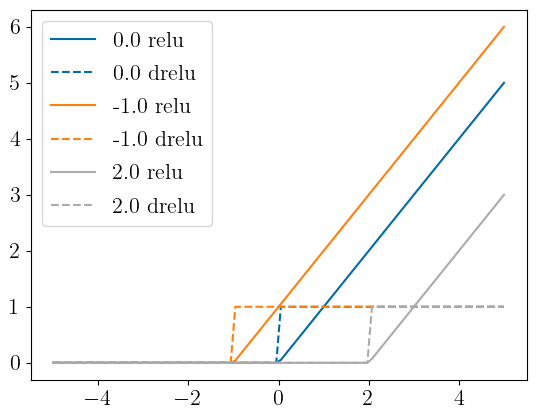

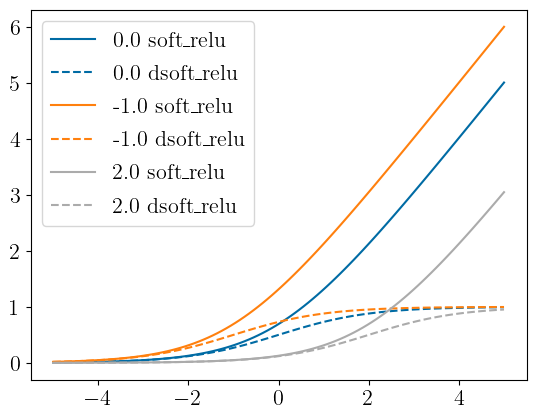

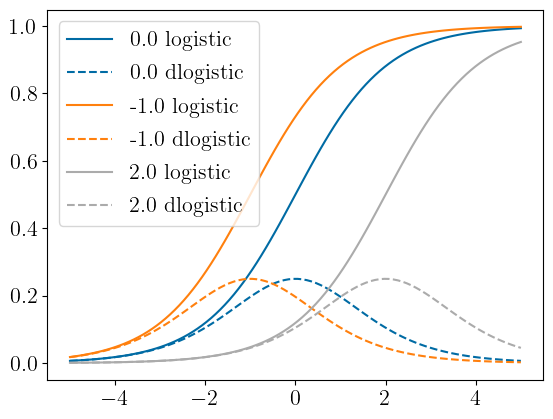

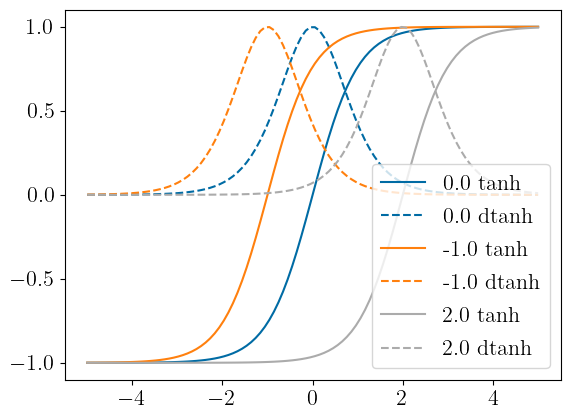

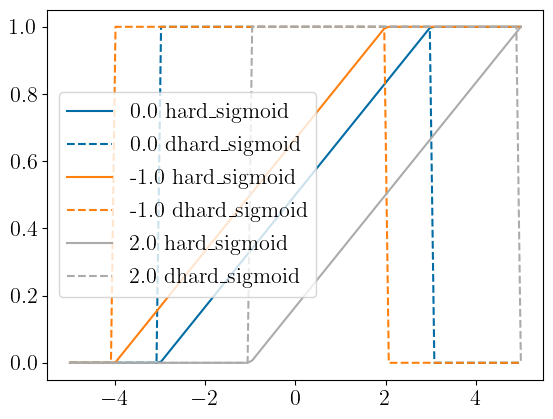

In [9]:
x = np.linspace(-5, 5, 100)

for act in [linear, relu, soft_relu, logistic, tanh, hard_sigmoid]:
    plt.plot()
    for offset, c in zip([0.0, -1.0, 2.0], ['C0', 'C1', 'C2']):
        y = act(x, offset=offset)
        plt.plot(x, y, label=str(offset) + str(" " + act.__name__).replace('_','\_'), c=c)
        
        d_act = dict_d_activation[act.__name__]
        y = d_act(x, offset=offset)
        plt.plot(x, y, label=str(offset) + str(" d" + act.__name__).replace('_','\_'), ls='--', c=c)

    
    
    plt.legend()
    plt.show()

# Analyse multilayer runs

In [1]:
import warnings
import matplotlib
warnings.filterwarnings("ignore", category=matplotlib.MatplotlibDeprecationWarning)

In [2]:
# %matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
# import pandas as pd
import json

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica",
    'font.size': 16,
    'figure.dpi': 100
})
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FormatStrFormatter
from src.microcircuit import *
from src.save_exp import *
import sys
# import pandas as pd
plt.style.use('tableau-colorblind10')
from scipy.stats import sem

#load autoreload, which automatically reloads the microcircuit.py upon execution
%reload_ext autoreload
%autoreload 1
%aimport src.microcircuit

In [27]:
# MAIN_PATH = 'experiments/exp142_errormc_multilayer_tune16etafw//'
MAIN_PATHS = ['experiments/exp147_errormc_multilayer_vizconn_scan_etafw/']

network_MC_list = []
network_params = []
for MAIN_PATH in MAIN_PATHS:
    for i in range(64):
        try:
            model_file = MAIN_PATH + f"/runs/lr{i}/model.pkl"
            with open(MAIN_PATH + f"/runs/lr{i}/params.json") as f:
                params_file = json.load(f)
            MC_list = src.save_exp.load(model_file)
            network_MC_list.append(MC_list)
            network_params.append(params_file)
        except:
            continue

In [28]:
len(network_MC_list)

16

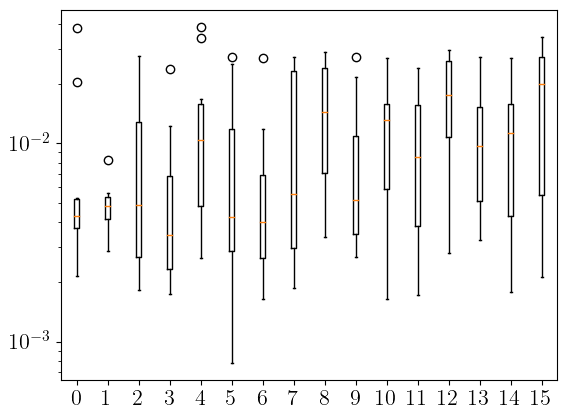

In [29]:
plt.figure()

for i, MC_list in enumerate(network_MC_list):

    test_mse = np.array([mc.MSE_test_time_series for mc in MC_list[1:]])
    test_mse = np.mean(test_mse, axis=1)
    

    plt.boxplot(test_mse, positions=[i])
plt.yscale('log')
plt.show()

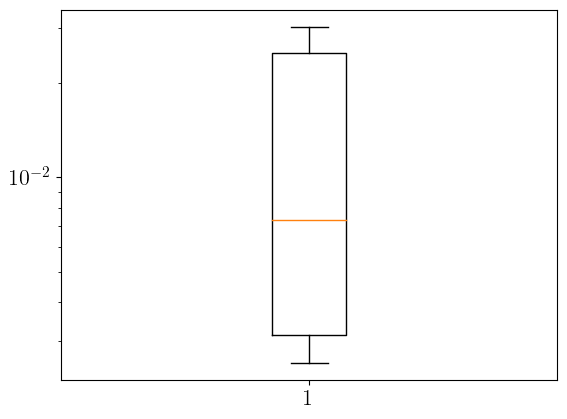

In [17]:
test_mse = np.array([mc.MSE_test_time_series for mc in MC_list[1:]])
test_mse = np.mean(test_mse, axis=1)
plt.figure()
plt.boxplot(test_mse)
plt.yscale('log')
plt.show()

No handles with labels found to put in legend.


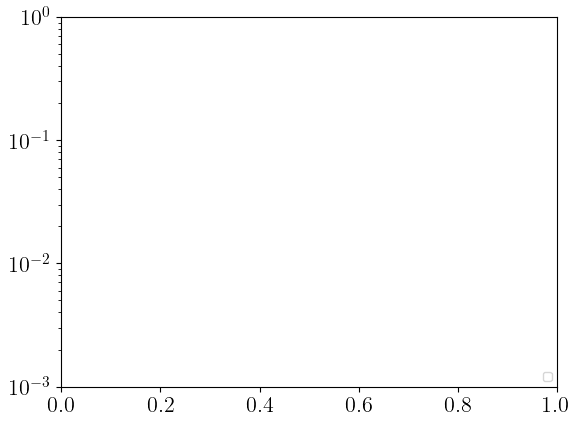

In [9]:
plt.figure()


test_mse_arr = []
):
    for j, mc in enumerate(MC_list[1:]):
        test_mse = mc.MSE_test_time_series
        # mean across time
        test_mse = np.mean(test_mse)
        test_mse_arr.append(test_mse)

        plt.scatter(i + 0.02*j,test_mse)
    plt.scatter([], [],label=str(i))
plt.legend(prop={'size': 8}, loc='lower right')
plt.ylim(1e-3, 1)
plt.yscale('log')
plt.show()

In [59]:
# model_file = "experiments/exp117_genMNIST_ANN_multiseed/model.pkl"
MAIN_PATHS = [
#     "experiments/exp134_genMNIST_scan_actnoise//",
#     "experiments/exp135_genMNIST_actnoise_onlyslope/",
#     "experiments/exp136_genMNIST_actnoise_onlyoffset/",
#     "experiments/exp143_genMNIST_slopenoise_multiseed/"
#     "experiments/exp144_genMNIST_actnoise_onlyoffset_noerroract/"
    "experiments/exp145_genMNIST_actnoise_both_multiseed/"
#     "experiments/exp137_genMNIST_hiddenstatic/",
             ]

network_MC_list = []
network_params = []
for MAIN_PATH in MAIN_PATHS:
    for i in range(64):
        try:
            model_file = MAIN_PATH + f"/runs/lr{i}/model.pkl"
            with open(MAIN_PATH + f"/runs/lr{i}/params.json") as f:
                params_file = json.load(f)
            MC_list = src.save_exp.load(model_file)
            network_MC_list.append(MC_list)
            network_params.append(params_file)
        except:
            continue


In [60]:
len(network_MC_list)

39

In [61]:
# for model in [mc, emc]:
# #     plt.imshow(model.rP_breve[-1].reshape(28,28))
# #     plt.show()
#     print(model.WPP[-1].max())

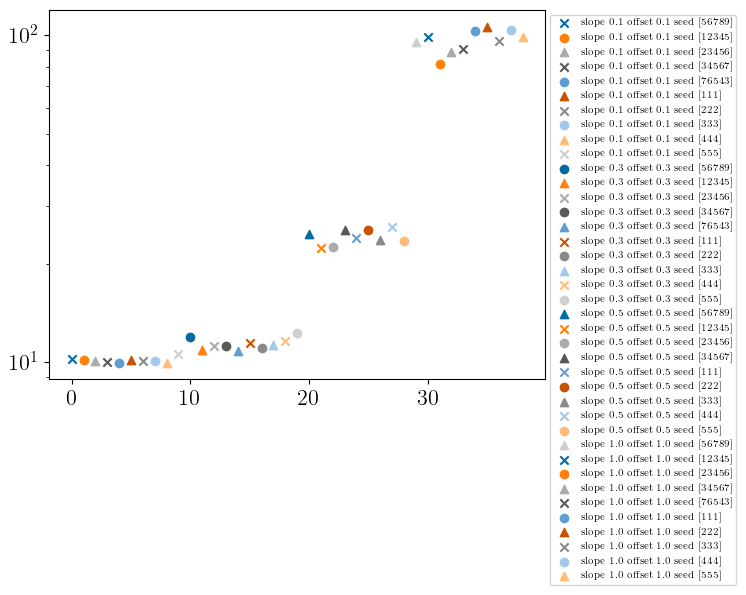

In [62]:
data = [MC_list[0].MSE_test_time_series for MC_list in network_MC_list]
data = [np.mean(x) for x in data]

markers = ['x', 'o', '^', 'D', 'd']

plt.figure()
for i, (dat, params) in enumerate(zip(data, network_params)):
    label = "slope " + str(params["activation_slope_std"]) \
                + " offset " + str(params["activation_offset_std"]) \
                + " seed " + str(params["random_seed"]) \
#                     + " eta " + str(params["eta_fw"])
    plt.scatter(i, dat, label=label, marker = markers[i%3])
plt.legend(prop={'size': 7}, bbox_to_anchor=[1, 1])
plt.yscale('log')
plt.show()

In [33]:
np.where(data==np.nanmin(data))[0].item()

0

In [54]:
# BEST_RUN = np.where(data==np.nanmin(data))[0].item()
BEST_RUN = -1

In [63]:
BEST_RUN

-1

In [64]:
mc1 = network_MC_list[BEST_RUN][0]

In [65]:
# mc1.activation

label: (array([5]),)
MSE: 91.5891539229627


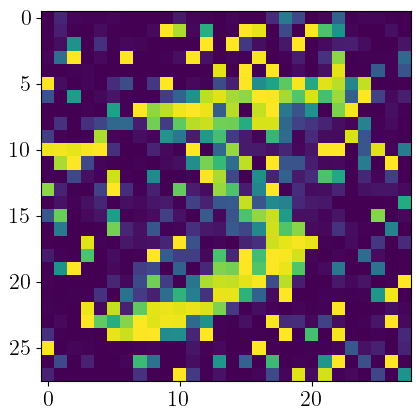

In [66]:
for i, (r0, target) in enumerate(zip(mc1.input_testing, mc1.target_testing)):
    mc1.evolve_system(r0=r0)
    if i % int(mc1.Tpres / mc1.dt) == int(mc1.Tpres / mc1.dt)-1:
        print("label:", np.where(r0==1))
        mse = np.linalg.norm(mc1.rP_breve[-1] - target)**2
        print("MSE:", mse)
        plt.figure()
        plt.imshow(mc1.rP_breve[-1].reshape(28,28))
        plt.show()
        break

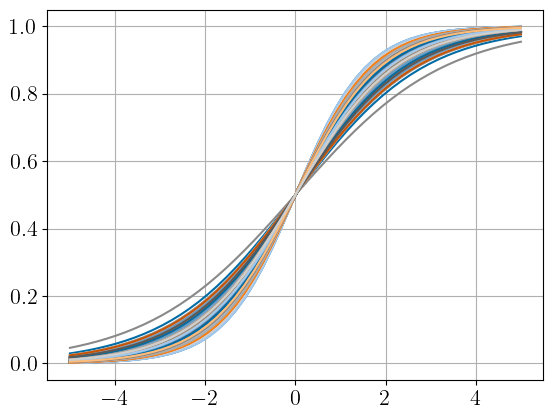

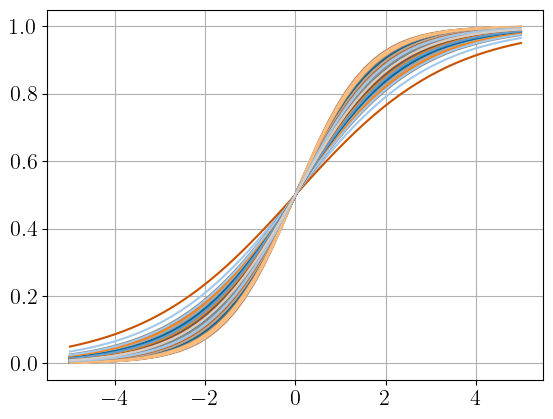

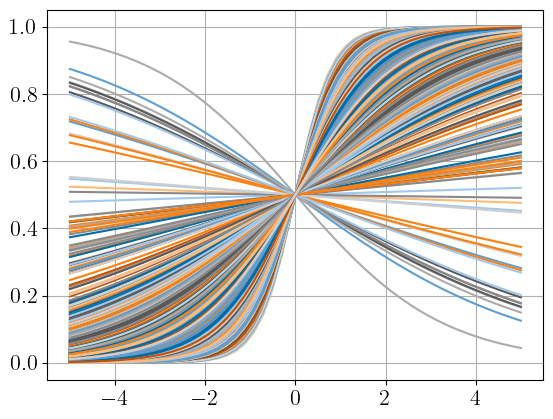

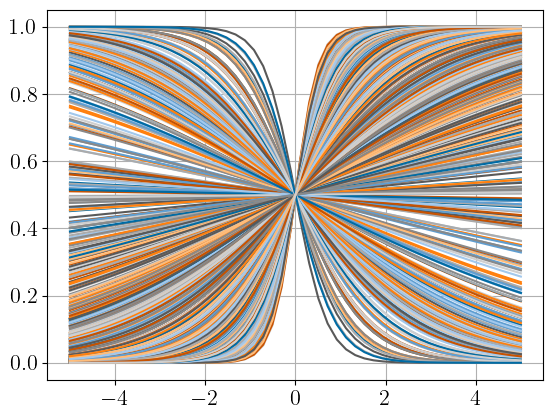

In [24]:
x = np.linspace(-5, 5, 50)
x = np.repeat(x, 1000).reshape(50, 1000)


for i, MC_list in enumerate([network_MC_list[0], network_MC_list[3], network_MC_list[20], network_MC_list[-1]]):
    plt.figure()
    act = MC_list[0].activation[0]
    y = act(x)
    ys = np.mean(y, axis=1)
    yerr = np.std(y, axis=1)
#     print(y.std())
#     plt.title(MC_list[0].activation_)
#     print(x.shape, y.shape, ys.shape, yerr.shape)
#     plt.errorbar(x[:,0], ys, yerr=yerr, capsize=3, label=str(i))
    for j in range(1000):
        plt.errorbar(x[:,j], y[:,j], capsize=3)#, label=str(i))
   
    
#     plt.legend()
    plt.grid()
    plt.show()

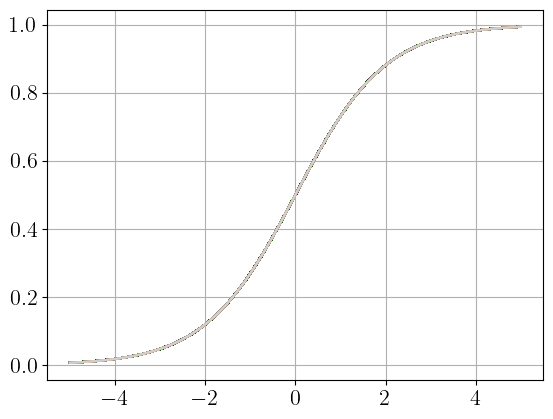

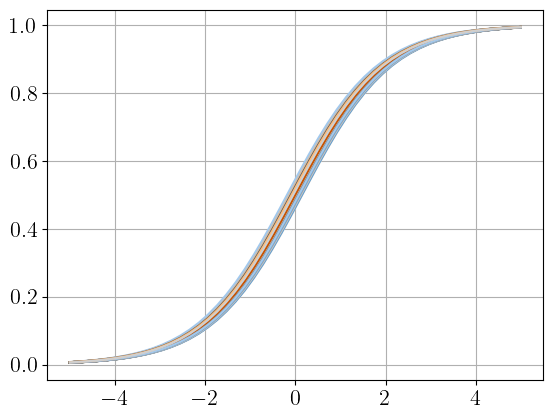

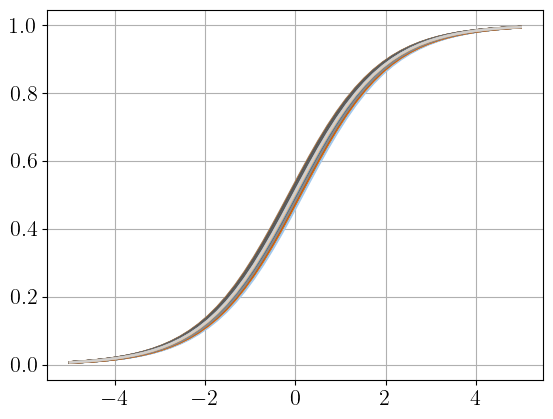

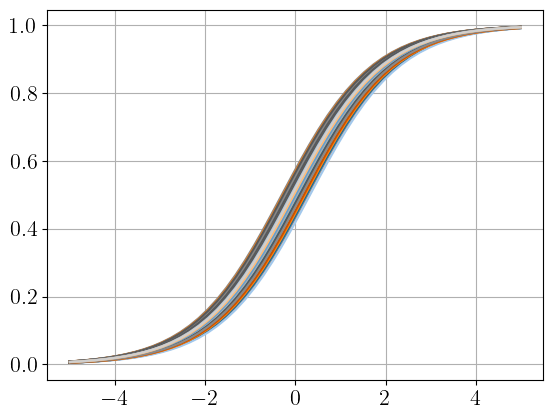

In [33]:
x = np.linspace(-5, 5, 50)
x = np.repeat(x, 1000).reshape(50, 1000)


for i, MC_list in enumerate([network_MC_list[0], network_MC_list[-5], network_MC_list[-4], network_MC_list[-1]]):
    plt.figure()
    act = MC_list[0].activation[0]
    y = act(x)
    ys = np.mean(y, axis=1)
    yerr = np.std(y, axis=1)
#     print(y.std())
#     plt.title(MC_list[0].activation_)
#     print(x.shape, y.shape, ys.shape, yerr.shape)
#     plt.errorbar(x[:,0], ys, yerr=yerr, capsize=3, label=str(i))
    for j in range(1000):
        plt.errorbar(x[:,j], y[:,j], capsize=3)#, label=str(i))
   
    
#     plt.legend()
    plt.grid()
    plt.show()

In [53]:
MAIN_PATH = 'experiments/exp128_implement_realistic_connectivity/'
# MAIN_PATH = 'experiments/exp139_check_skipconn_implementation/2_layered_fwd/'

model_file = MAIN_PATH + f"/model.pkl"
MC_list = src.save_exp.load(model_file)

In [56]:
MC_list[1].activation

[functools.partial(<function tanh at 0x17bd88b80>, slope=array([ 2.02073905, -0.81392255,  0.2817658 ,  0.40742629]), offset=array([-0.38443169, -0.40857375,  0.71132858,  1.82783965])),
 functools.partial(<function tanh at 0x17bd88b80>, slope=array([-0.69366027, -0.40680855,  1.21136512, -0.92049453]), offset=array([-0.54485645,  0.22213938,  0.18920541, -0.52149204])),
 functools.partial(<function tanh at 0x17bd88b80>, slope=array([-0.07440071,  3.27086394,  1.06004781,  0.1387951 ]), offset=array([ 0.19526769, -0.42585436, -0.67487835,  0.13046678])),
 functools.partial(<function tanh at 0x17bd88b80>, slope=array([2.56437353, 1.1672937 , 0.65532961, 0.3587213 ]), offset=array([ 0.94262331,  1.44997652, -0.40222958, -0.58955272])),
 functools.partial(<function tanh at 0x17bd88b80>, slope=array([ 1.21641993, -1.08462802,  0.8947811 ,  0.33996993]), offset=array([ 1.07008937,  0.10314329,  1.0167864 , -0.18229862]))]

In [5]:
MC_list[1].WPP

[array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ],
        [ 0.44814712,  0.9278092 ,  0.13590924, -0.55639935,  0.        ,
          0.        ,  0.        ],
        [ 0.44814712,  0.9278092 ,  0.13590924, -0.55639935,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.86513067,
          0.86513067,  0.        ]])]

In [213]:
MC_list[1].WPP

[array([[ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
        [ 0.45,  0.93,  0.14, -0.56,  0.  ,  0.  ,  0.  ],
        [ 0.45,  0.93,  0.14, -0.56,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ,  0.  ,  0.87,  0.87,  0.  ]])]

In [18]:
MAIN_PATH = 'experiments/exp140_errormc_multilayer_vizconn/'
PATH_APPENDIX = ['/2-1/','/4-2-1/','/8-4-2-1/','/16-8-4-2-1/','/32-16-8-4-2-1/']
PATHS = ['fill_diag', 'fill_all', 'fill_scaled']
NAME = ''


markers = ['x', 'o', '^', 'D', 'd']

network_MC_list = []
for PATH in PATHS:
    for PATH_APP in PATH_APPENDIX:
        model_file = MAIN_PATH + PATH + '/' + PATH_APP + '/errormc/model.pkl'
        MC_list = src.save_exp.load(model_file)
        network_MC_list.append(MC_list)

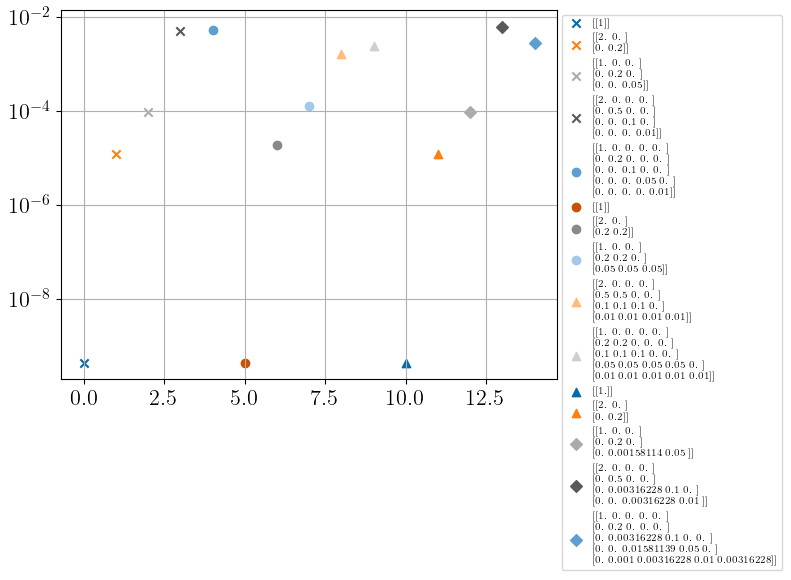

In [22]:
plt.figure()
for i, MC_list in enumerate(network_MC_list):
    mse = np.array([mc.MSE_test_time_series for mc in MC_list[1:]])
    mse = np.median(mse)
    lab = str(MC_list[1].eta_fw)
#     print(f"{lab}, {mse}")
    plt.scatter(i, mse, label=lab, marker=markers[i//4])
plt.legend(prop={'size': 7}, bbox_to_anchor=(1.0,1.0))
plt.yscale('log')
plt.grid()
plt.show()

In [15]:
network_MC_list[-1][1].eta_fw

array([[1.        , 0.        , 0.        ],
       [0.        , 0.2       , 0.        ],
       [0.        , 0.00158114, 0.05      ]])

In [16]:
# model_file = 'experiments/exp140_errormc_multilayer_vizconn/fill_scaled/16-8-4-2-1/errormc/model.pkl'
# MC_list = src.save_exp.load(model_file)

In [17]:
# MC_list[-1].eta_fw

In [30]:
# now load errormcs
MAIN_PATHS = [
    "experiments/exp156_errormc_multilayer_vizconn_scan_etafw/"
#     'experiments/exp149_genMNIST_abl_vanilla_vizconn_multiseed/',
#     'experiments/exp150_genMNIST_abl_vanilla_hierarch_multiseed/',
#     'experiments/exp151_genMNIST_abl_vanilla_vizconn_200epochs_multiseed/',
#     'experiments/exp152_genMNIST_abl_vanilla_hierarch_200epochs_multiseed/',
]

network_seed_MC_list = []
for MAIN_PATH in MAIN_PATHS:
    for i in range(200):
        try:
            model_file = MAIN_PATH + f'/runs/lr{i}/model.pkl'
            MC_list = src.save_exp.load(model_file)
            network_seed_MC_list.append(MC_list)
        except:
            pass

In [33]:
# re-arrange into seeds
SEEDS = 10

# network_MC_list = [network_seed_MC_list[i: i+SEEDS] for i in range(0, len(network_seed_MC_list), SEEDS)]
network_MC_list = [MC_list[1:] for MC_list in network_seed_MC_list]
# network_MC_list = network_seed_MC_list

len(network_MC_list)

16

In [34]:
mse_arr = []

for MC_list in network_MC_list:
    
    # extract MSE
    val_mse = np.array([mc.MSE_test_time_series for mc in MC_list])
#     print(val_mse.shape)
    val_mse = val_mse.reshape(-1,200)
    # mean across time
    val_mse = np.mean(val_mse, axis=-1)
    # median across seeds
    val_mse = np.median(val_mse, axis=0)
    
    mse_arr.append(val_mse)
    
mse_arr = np.array(mse_arr)

In [37]:
np.min(mse_arr), np.argmin(mse_arr)

(0.0019273013078493948, 10)

In [67]:
np.set_printoptions(precision=5, linewidth=10000, suppress=True)
network_MC_list[10][0].WPP[0][16:,16:]

array([[ 0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.     ,  0.     

In [209]:
MAIN_PATHS = ["experiments/exp168_implement_dPC/4-2-1_dPC_linear_task",
         "experiments/exp168_implement_dPC/4-2-1_sacramento_linear_task/"]

network_MC_list = []
for MAIN_PATH in MAIN_PATHS:
    model_file = MAIN_PATH + f'/model.pkl'
    MC_list = src.save_exp.load(model_file)
    network_MC_list.append(MC_list)

In [210]:
network_MC_list[0][1].WPP

[array([[ 0.42836618,  0.1522614 , -1.0368894 ,  1.11317984],
        [-0.83064304, -1.05129784,  0.87488484, -0.28883015]]),
 array([[-0.96464021, -1.15434736]])]

In [211]:
network_MC_list[1][1].vapi

[array([ 6.61660945e-05, -2.39136393e-05])]

In [212]:
MC_list[1].BPP[0] @ MC_list[1].WPP[1]

array([[ 0.7931486 , -0.28665844],
       [-0.28665844,  0.10360361]])

In [213]:
MC_list[1].WPP[1]

array([[ 0.8905889 , -0.32187515]])

9.065353734708397e-05
0.00022070297115084082


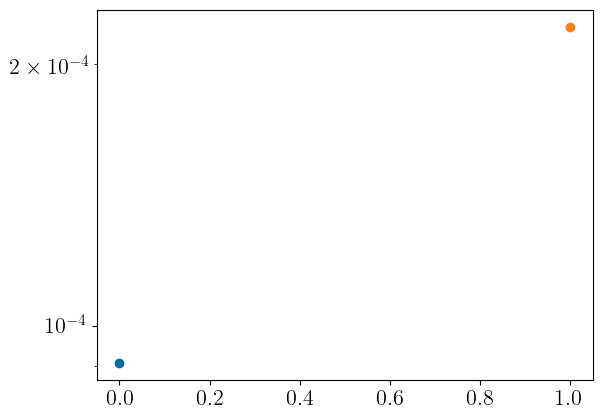

In [216]:
plt.figure()
plt.yscale('log')
for i, MC_list in enumerate(network_MC_list):
    print(np.mean(MC_list[1].MSE_test_time_series))
    plt.scatter(i, np.mean(MC_list[1].MSE_test_time_series))#, yerr=np.std(MC_list[1].MSE_test_time_series))
# plt.ylim(1e-4, 1)
plt.show()

In [231]:
mc = network_MC_list[0][1]

for i, (r0, tgt) in enumerate(zip(mc.input_testing, mc.target_testing)):
    mc.evolve_system(r0=r0, u_tgt=[tgt])
#     print("tgt", tgt)
#     print("uPbreve", mc.uP_breve)
    if i > 10:
        break

In [232]:
mc.BPP[0] @ mc.rP_breve[1] + mc.BPI[0] @ mc.rI_breve[0]

array([-0.00072627, -0.00144208])

In [233]:
mc.vapi

[array([-0.00073532, -0.00145225])]

In [229]:
mc.BPP[0] @ mc.rP_breve[1] + mc.BPI[0] @ mc.rI_breve[0]

array([-0.0009072 ,  0.00032807])

In [230]:
mc.vapi

[array([-0.00090699,  0.00032799])]

In [11]:
MAIN_PATH = 'experiments/'
PATHS = ['exp169_multilayer_dPC_nonlin_noUS/', 'exp170_multilayer_dPC_nonlin_US']
PATH_APPENDIX = ['/2-1/','/4-2-1/','/8-4-2-1/','/16-8-4-2-1/','/32-16-8-4-2-1/']
# PATH_APPENDIX = ['dPC', 'untrained_dPC']
NAME = ''

In [12]:
network_MC_list = []
for PATH in PATHS:
    for PATH_APP in PATH_APPENDIX:
        model_file = MAIN_PATH + PATH + '/' + PATH_APP + '/dPC/model.pkl'
        MC_list = src.save_exp.load(model_file)
        network_MC_list.append(MC_list)

[2, 1] False 2.7369634256656837e-05
[4, 2, 1] False 0.0003644260852812987
[8, 4, 2, 1] False 0.007174744133439794
[16, 8, 4, 2, 1] False 0.025707523576239896
[32, 16, 8, 4, 2, 1] False 0.013491598328136012
[2, 1] True 2.423664415854647e-05
[4, 2, 1] True 0.0003079970863520824
[8, 4, 2, 1] True 0.007429836938073368
[16, 8, 4, 2, 1] True 0.02756783951894647
[32, 16, 8, 4, 2, 1] True 0.01181607058345881


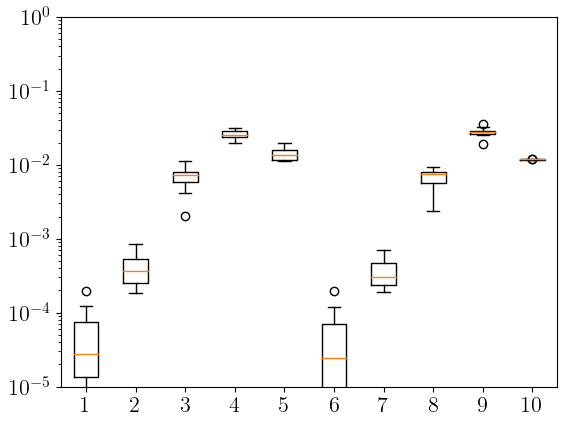

In [18]:
labels = []
for MC_list in network_MC_list:
    mse = [mc.MSE_test_time_series for mc in MC_list[1:]]
    mse = np.array(mse)
    mse = np.mean(mse, axis=-1)
    mse = np.median(mse)
    print(MC_list[1].layers, MC_list[1].dWPP_use_activation, mse)
#     labels.append(MC_list[1].layers, MC_list[1].dWPP_use_activation)

mse = [[mc.MSE_test_time_series for mc in MC_list[1:]] for MC_list in network_MC_list]
mse = np.array(mse)
mse = np.mean(mse, axis=-1)
mse = mse.T

plt.figure()
plt.boxplot(mse)
plt.yscale('log')
plt.ylim(1e-5, 1)
plt.show()

In [10]:
mse.shape

(10, 8)

In [6]:
MAIN_PATH = 'experiments/multilayer_comparison_compiled'
PATHS = ['/16-8-4-2-1/','/32-16-8-4-2-1/']
PATH_APPENDIX = ['ann']
NAME = ''

In [7]:
network_MC_list = []
for PATH in PATHS:
    for PATH_APP in PATH_APPENDIX:
        model_file = MAIN_PATH + PATH + '/' + PATH_APP + '/model.pkl'
        MC_list = src.save_exp.load(model_file)
        network_MC_list.append(MC_list)

[4.273533663215256e-05, 4.4609924533430817e-05, 0.0008050475732659351, 0.0035634628441226614]
[2.6728903094788962e-05, -1.857504922087122e-05, 2.1141481349800045e-06, -7.39961815757744e-05, 0.0013197665136770523]


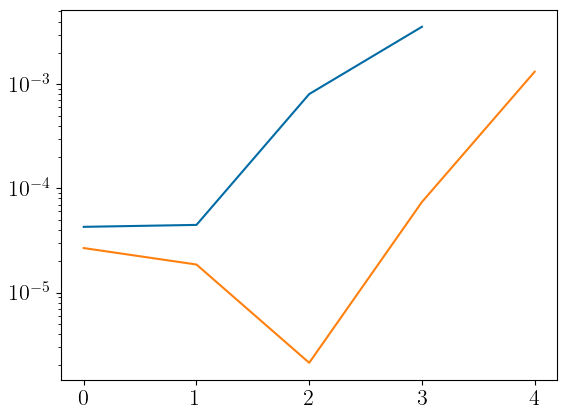

In [52]:
plt.figure()
for i, MC_list in enumerate(network_MC_list):
    uI_breve = [mc.uI_breve for mc in MC_list[1:]]
    uI_breve = [np.mean([arr[i] for arr in uI_breve]) for i in range(len(uI_breve[0]))]
    print(uI_breve)
    uI_breve = np.abs(uI_breve)
    plt.plot(range(len(uI_breve)), uI_breve)

plt.semilogy()
plt.show()

[6.025698361945442e-08, -3.8318800842270714e-07, -2.9090233203277174e-06, 3.0373913264741475e-06]
[1.3790825212836182e-07, 1.363280907811329e-07, 5.224689174023528e-08, 1.4709884430426395e-06, -1.3147351502074144e-05]


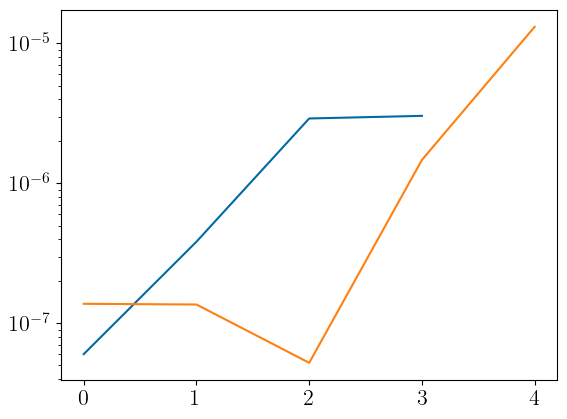

In [53]:
plt.figure()
for i, MC_list in enumerate(network_MC_list):
    uI_breve = [mc.dWPP for mc in MC_list[1:]]
    uI_breve = [np.mean([arr[i] for arr in uI_breve]) for i in range(len(uI_breve[0]))]
    print(uI_breve)
    uI_breve = np.abs(uI_breve)
    plt.plot(range(len(uI_breve)), uI_breve)

plt.semilogy()
plt.show()

In [72]:
mc = network_MC_list[0][1:][0]
for i in range(len(mc.WPP_time_series[-1])):
    diff = mc.WPP_time_series[-1][i] - mc.WPP_time_series[0][i]
    print(mc.layers[i], np.mean(diff), np.std(diff))

16 0.06013642827963275 0.4872457716852334
8 -0.02032785410820219 0.22415371679574672
4 0.0019251610856910115 0.10842203496129275
2 0.011690616177815388 0.02123684393486755


In [188]:
a = [1,2,3]
i = 3
a[:i] = [0 for _ in range(i)]
a

[0, 0, 0]

In [87]:
# PATHS = ['experiments/multilayer_comparison_compiled/8-4-2-1/sacramento2018/',
#          'experiments/exp179_errormc_multilayer_perfect_SPS/8-4-2-1/sacramento2018/',
#         'experiments/exp180_errormc_multilayer_perfect_SPS_debug/',]
# PATHS = ['experiments/multilayer_comparison_compiled/8-4-2-1/dPC/',
#         'experiments/exp181_errormc_multilayer_perfect_SPS_dPC_debug/',
#         ]

PATHS = ['experiments/multilayer_comparison_compiled/8-4-2-1/sacramento2018/',
         'experiments/exp179_errormc_multilayer_perfect_SPS/8-4-2-1/sacramento2018/',
         'experiments/multilayer_comparison_compiled/8-4-2-1/dPC/',
         'experiments/exp179_errormc_multilayer_perfect_SPS/8-4-2-1/dPC/',
        ]
# PATHS = ['experiments/multilayer_comparison_compiled/16-8-4-2-1/sacramento2018/',
#          'experiments/exp179_errormc_multilayer_perfect_SPS/16-8-4-2-1/sacramento2018/',
#          'experiments/multilayer_comparison_compiled/16-8-4-2-1/dPC/',
#          'experiments/exp179_errormc_multilayer_perfect_SPS/16-8-4-2-1/dPC/',
#         ]
# PATHS = ['experiments/multilayer_comparison_compiled/32-16-8-4-2-1/sacramento2018/',
#          'experiments/exp179_errormc_multilayer_perfect_SPS/32-16-8-4-2-1/sacramento2018/',
#          'experiments/multilayer_comparison_compiled/32-16-8-4-2-1/dPC/',
#          'experiments/exp179_errormc_multilayer_perfect_SPS/32-16-8-4-2-1/dPC/',
#         ]
NAME = ''

In [88]:
network_MC_list = []
# for i in range(15):
#     model_file = MAIN_PATH + f'/runs/lr{i}/model.pkl'
for PATH in PATHS:
    model_file = PATH + '/model.pkl'
    MC_list = src.save_exp.load(model_file)
    network_MC_list.append(MC_list)

In [89]:
# network_MC_list

[0.1, 0.02, 0.002] 0.008311382520930291 0.007061183911255204 0.0012650841296739448
[1, 0.2, 0.05] 0.005555554105169471 0.0021149007841951327 0.0017731323950882687
[0.1, 0.02, 0.002] 0.0050897910340270795 0.0026605721895170964 0.0017199435627649716
[1, 0.2, 0.05] 0.0006313099858621771 1.0700569110082291e-05 1.0010354407877253e-05


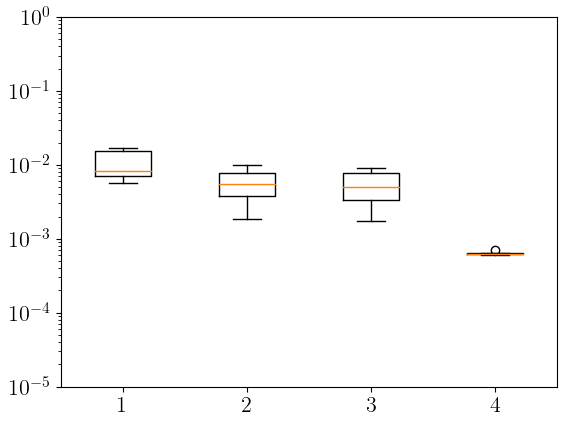

In [90]:
labels = []
plt.figure()
mse_arr = []
for MC_list in network_MC_list:
    mse = [mc.MSE_test_time_series for mc in MC_list[1:]]
    mse = np.array(mse)
    mse = np.mean(mse, axis=-1)
    # mse = np.median(mse)
    print(MC_list[1].eta_fw, np.median(mse), np.quantile(mse, q=0.75)- np.median(mse),np.median(mse)-np.quantile(mse, q=0.25))
    #     labels.append(MC_list[1].layers, MC_list[1].dWPP_use_activation)

    # mse = [[mc.MSE_test_time_series for mc in MC_list[1:]] for MC_list in network_MC_list]
    # mse = np.array(mse)
    # mse = np.mean(mse, axis=-1)
    # mse = mse.T
    mse_arr.append(mse)


plt.boxplot(mse_arr)
plt.yscale('log')
plt.ylim(1e-5, 1)
plt.show()

In [91]:
mc = network_MC_list[2][1]
[mc.gbas / (mc.gl + mc.gbas + mc.gapi) * WPP - mc.gden / (mc.gl + mc.gden) * WIP for WPP, WIP in zip(mc.WPP[1:], mc.WIP)]

[array([[-0.21428262, -0.07470783,  0.4722312 , -0.45280721],
        [ 0.41882437,  0.51325273, -0.31469551,  0.42995587]]),
 array([[-0.05119882,  0.20698867]])]